
# Convert Pytorch Resnet50 to CoreML via ONNX

Load packaged Resnet50 model for Torch, convert to ONNX, then to CoreML, checking as we go. 

This notebook:
- Loads the packaged Torch Resnet50 (`torchvision.models.resnet50(pretrained=True)`), 
- Converts the Torch model (name **torchm**) to ONNX (name **t2o** ), then 
- Converts the ONNX model to CoreML(name **t2c** )
- Checks at each step that the models work.

On the first attempt, the CoreML model **t2c** (the result of the *ONNX->CoreML* conversion) fails. So:
- Examine the model using `coremltools` and `Netron`.
- Edit the model (attempt *model surgery*) to fix the problems.
- Surgery is attempted, patient survives, and the CoreML model is re-validated, and ... works!

Show selected results.

### Links

> [10-Intro-resnet50-convert-compare](10-Intro-resnet50-convert-compare.ipynb) - Intro notebook, contains context and discussion. 
>
> [40-compare-torch-onnx-coreml](40-compare-torch-onnx-coreml.ipynb) - Notebook for comparisons between these and other models.  
>
> [coreml_help](https://mcsieber.github.io/coreml_help.html) - Documentation for helper module   
>
> [pred_help](https://mcsieber.github.io/pred_help.html) - - - Documentation for helper module  


The cell below is common setup for this and other notebooks. You do have to run it, but you can ignore it otherwise.

In [3]:
# Notebook setup (initially %load(ed) from 'notebook_setup.py')
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# mcs utilities and helpers
from   ms_util import *

#Project Setup - Names & Commonly Used Values
project_name   = 'compare'   # Used as prefix for several derived names below
model_name     = 'resnet50'
model_arch     = 'Resnet50'   # Resnet50 , Resnet34, etc ...
img_size       = 300
batch_size     = 32

# %run -i {user_lib}/finish_setup.py [--show [Proj Paths Env] | None | All ] 
#
%run -i {user_lib}/finish_setup.py --show Proj

data_root       =  /Volumes/ArielD/storage
data_dir        =  /Volumes/ArielD/storage/data
proj_data_dir   =  /Volumes/ArielD/storage/data/compare
project_name    =  compare
proj_data_dir   =  /Volumes/ArielD/storage/data/compare
proj_dir        =  /Users/mcsieber/storage/notebooks/compare
model_name      =  resnet50
model_arch      =  Resnet50
models_dir      =  /Volumes/ArielD/storage/data/compare/models
img_size        =  300
batch_size      =  32



## Additional Setup
Import Image functions and helper modules I wrote for working with CoreML and predictions from multiple kinds of model(Torch, ONNX, and CoreML). `coreml_help` is mostly a front-end to `coremltools`, which does all the heavy lifting.

In [4]:
from PIL import Image
from PIL import ImageOps
from pred_help import *
from coreml_help import *
#
mlmodels_dir  = data_dir/'mlmodels'
resize_method = Image.NEAREST

#### Test Data - Get and prepare test images

In [5]:
test_root     = data_root/'data'
test_data_dir = data_dir/'test'
imagenet_dir  = data_dir/'imagenet'
imagenet_path = imagenet_dir/'img_net_labels.txt'

In [6]:
dogcat_dir    = test_root/'dogscats/large/valid-large'
flowers_dir   = test_root/'flowers/data'
fruit_dir     = test_root/'food_poc/data'
food_dir      = Path('/Volumes/ArielD/storage/data/food/images')
pp((dogcat_dir, flowers_dir,food_dir,fruit_dir))

dogcat_dir     =  PosixPath('/Volumes/ArielD/storage/data/dogscats/large/valid-large')
flowers_dir    =  PosixPath('/Volumes/ArielD/storage/data/flowers/data')
food_dir       =  PosixPath('/Volumes/ArielD/storage/data/food/images')
fruit_dir      =  PosixPath('/Volumes/ArielD/storage/data/food_poc/data')


Get random images from various test image sets

In [7]:
ni  = 5         # Get this many images per directory
max_sample = 400  # Max sample range (set limit in case it is a huge directory)
#
t0 = get_rand_images(food_dir,   n_images=int(ni*3), search_limit=max_sample)
t1 = get_rand_images(dogcat_dir, n_images=ni, search_limit=max_sample)
t2 = get_rand_images(flowers_dir,n_images=ni, search_limit=max_sample)
t3 = get_rand_images(fruit_dir,   n_images=ni, search_limit=max_sample)
test_imgs = t0+t1+t2+t3
#
f"{len(test_imgs)} test images"

'29 test images'

Get validation images to sanity check the models as we create or convert them

In [8]:
validation_imgs = [
    Path('/Volumes/ArielD/storage/data/food_poc/data/apples/apple_029.jpg'),
    Path('/Volumes/ArielD/storage/data/compare/data/bana/bana_000.jpg'), ]

#### ImageNet - Read in Labels
These are the [1000 class labels](https://s3.amazonaws.com/onnx-model-zoo/synset.txt) for ImageNet. 

In [9]:
with open(imagenet_path, 'r') as list_ : 
    inet_labels = [line.rstrip() for line in list_ ]
labels = inet_labels # synonym
f"{len(labels)} imagenet labels"

'1000 imagenet labels'

#### ImageNet - Calculate Scale and Bias for ONNX and CoreML models

As recommended, input images for the ONNX model are normalized
using the mean and standard deviation for **ImageNet**.
(For details, see Help or Notes for `imagenet_normalize`):

For the CoreML models, we use the values above to calculate an *image scale*
and (Red, Green, Blue) *channel biases* that acheive the same effect.

In [10]:
mean = np.array(imagenet.mean)
std  = np.array(imagenet.std)

# For CoreML from ONNX, calculate scale and bias to reproduce normalization
ppargs = dict(
    image_scale= 1/(255.0*std.mean()),
    red_bias   = - mean[0]/std[0],
    green_bias = - mean[1]/std[1],
    blue_bias  = - mean[2]/std[2]
)
ppargs

{'image_scale': 0.01735207357279195,
 'red_bias': -2.1179039301310043,
 'green_bias': -2.0357142857142856,
 'blue_bias': -1.8044444444444445}

## Torch
Get Resnet50, Convert, Validate

In [11]:
import torch
import torchvision

TORCH - Paths for  Torch Resnet ,  for Torch->ONNX,  and for the Torch->ONNX->CoreML conversion

In [12]:
# Torch Resnet50
torchm = None
torchm_name = 'torch.pth'
torchm_path = models_dir/torchm_name ; torchm_path

PosixPath('/Volumes/ArielD/storage/data/compare/models/torch.pth')

TORCH - Get the Resnet50 supplied as part of the torchvision package. Set it to "eval" mode so that we can get some predictions

In [13]:
torchm = torchvision.models.resnet50(pretrained=True)

In [14]:
model  = torchm.eval()  # Must set to evaluation mode to generate predictions

In [15]:
torch.save(model,torchm_path)

#### Torch Quick Check
Use the model to identify a couple of images that *should* be easily identifiable.  If the model does not categorize these correctly, there is a error of some sort in the setup or downloaded images or downloaded model.

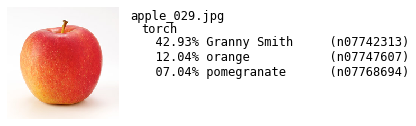

In [16]:
for img_path in validation_imgs:
    pred = pred_for_torch(model,Image.open(img_path),labels=inet_labels)
    if show_pred(img_path,pred, model_id='torch') is None: break

### Torch -> ONNX

T2O - These cells convert the Torch model to ONNX.

For conversion create "dummy" pytorch input variables.
It is my understanding that input is required because
PyTorch executes the model as part of the conversion process.

In [17]:
import onnx
import torch.onnx
from torch.autograd import Variable
import onnxruntime as ort

In [18]:
t2o_name = 't2o.onnx'
t2o_path = models_dir/t2o_name ; t2o_path

PosixPath('/Volumes/ArielD/storage/data/compare/models/t2o.onnx')

In [19]:
v_in        = torch.randn(batch_size,3, img_size, img_size)
dummy_input = Variable(v_in)

In [22]:
torch.onnx.export(torchm, dummy_input,
                  t2o_path,
                  input_names=['image'],
                  output_names=['imagenet'],
                  verbose=False,
                  strip_doc_string=False);

In [23]:
t2o = onnx.load(t2o_path)
onnx.checker.check_model(t2o)

#### T2O Quick Check

In [24]:
t2o_rt  = ort.InferenceSession(t2o_path.as_posix())

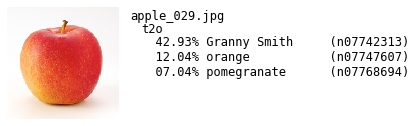

In [25]:
for img_path in validation_imgs:
    pred = pred_for_onnx(t2o_rt,Image.open(img_path),labels=inet_labels)
    if show_pred(img_path,pred,model_id='t2o') is None : break

### Torch - ONNX -> Coreml 
T2C - These cells convert the intermediate ONNX model to CoreML

In [26]:
from onnx_coreml import convert
from coremltools import models as cm

In [27]:
t2c_name = 't2c.mlmodel'
t2c_path = models_dir/t2c_name ; t2c_path 

PosixPath('/Volumes/ArielD/storage/data/compare/models/t2c.mlmodel')

In [ ]:
t2c = convert( t2o,
               mode='classifier',
               image_input_names=['image'],
               class_labels=imagenet_path.as_posix(),
               preprocessing_args=ppargs );

In [29]:
t2c.save(t2c_path.as_posix())

#### T2C Quick Check

In [30]:
t2c  = cm.MLModel(t2c_path.as_posix())

Exception from pred_for_o2c(input=image, output=imagenet)
{
    NSLocalizedDescription = "The size of the output layer 'imagenet' in the neural network does not match the number of classes in the classifier.";
}


IndexError: list index out of range

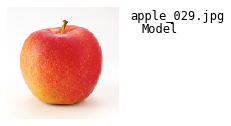

In [31]:
for img_path in validation_imgs:
    pred = pred_for_o2c(t2c,Image.open(img_path),labels=inet_labels)
    if show_pred(img_path,pred) is None: break

>**The converted CoreML model** appears to have a problem!

### T2C - Examine the  *Torch-to-ONNX-to-CoreML* Model

This answers one of the questions I had about converting Resnet50 models from Torch to CoreML: Would conversion of an off-the-shelf model have any issues?  The answer appears to be "yes".

Below are the head and tail for the **t2c** CoreML model. `CoremlBrowser` and its methods are simple helpers that I wrote. `help(CoremlBrowser)` will display its documentation.  The source is in `coreml_help.py`

Let's take a look at the **t2c** model and see if we can fix it. First, generate a browser for the model. 

>#### A Note on CoreML model names:
- *"mlmodel"* can be a confusing reference if you are just learning about CoreML. 
- The `.mlmodel` *file* is the protobuf spec for the CoreML model. The name and path above refer to this file. 
- When this spec file is loaded into Python, it becomes a *'spec'* object with a type of `Model_pb2.Model`. The *spec* is compiled to create the CoreML model.
- In Python code, *"MLModel"* refers to the `MLModel` Class or an object of this class (ie. the "CoreML model"), *not* the spec.
- When a CoreML model is created (compiled) from the *spec*, the model is written to a directory suffixed by `.mlmodelc`.
- When you see a variable with "mlmodel" in the name, it might be referring to the spec, or it might be referring to the CoreML model (the MLModel Class object). You have to check to know which.



In [32]:
tcb = CoremlBrowser(t2c_path); tcb

Using shape info from compilation output
mlmodel_path      = /Volumes/ArielD/storage/data/compare/models/t2c.mlmodel
layer_count       = 175
layer_shapes_count = 176

layer_count       = input {
  name: "image"
  type {
    imageType {
      width: 300
      height: 300
      colorSpace: RGB
    }
  }
}
output {
  name: "imagenet"
  type {
    dictionaryType {
      stringKeyType {
      }
    }
  }
}
output {
  name: "classLabel"
  type {
    stringType {
    }
  }
}
predictedFeatureName: "classLabel"
predictedProbabilitiesName: "imagenet"



T2C - Look at the head and tail of the model.  For our purposes here, this output is adequate.  If you want to do a more extensive examination, I recommend **[Netron](https://github.com/lutzroeder/netron)**.

In [33]:
tcb.show_nn(0,3)  # equivalent to show_head(tcb)

Lay Name      In         Out         Shapes          Type,Chan(s)         Size,Stride,Dilation,#Wts
  0 321       [image]    [321]       c h w:  64 150   conv     64x3       sz:7x7  str:2x2  dil:1x1  wc:9408
  1 322       [321]      [322]       c h w:  64 150   bnorm    64         ep:1.000e-05  wc:128
  2 323       [322]      [323]       c h w:  64 150   ReLU     


In [34]:
show_tail(tcb)

Lay Name      In         Out         Shapes          Type,Chan(s)         Size,Stride,Dilation,#Wts
172 493       [492]      [493]       c h w:  2048 1   pool                sz:0x0  str:1x1
173 501       [493]      [501]       c h w:  -1 1  1  reshape             target:[32, -1, 1, 1]
174 imagenet  [501]      [imagenet]  c h w:  1000 1   innerp   1000x2048  wc:2048000


### T2C - Model Surgery
The compilation reported a problem with Layer name "501". The "501" operation is a a *reshape* with a target of `[32,-1,1,1]`. If I had to guess - and I am only guessing - I'd speculate that the "32" is suspicious, and that it might be possible to remove layer "501", because the previous layer - "493" has an *output shape* of 2048 1, which matches  with layer "imagenet"'s *input shape* of 2048.  

So, let's try this: 
- Save this version of the model as version 0, the "original coversion"
- Connect layer "493" to layer "imagenet", 
- Remove layer "501", 
- Recompile the model from the edited `spec`, (The edits are done on the spec that is saved in the browser **tcb** )
- Try another "quick check".
- If that succeeds, save the corrected model, if not
- Analyse, revise and check the model until it does.


In [35]:
t2c_v0_path = models_dir/'t2c_v0.mlmodel' ; t2c_v0_path

PosixPath('/Volumes/ArielD/storage/data/compare/models/t2c_v0.mlmodel')

In [36]:
t2c.save(t2c_v0_path)

In [37]:
tcb.connect_layers(from_='493', to_='imagenet')

LayerAudit(changed_layer='imagenet', input_before=['501'], input_after=['493'], error=None)

In [38]:
tcb.delete_layers(['501'])

[{'deleted_layer': '501', 'input': ['493'], 'output': ['501']}]

In [39]:
show_tail(tcb)

Lay Name      In         Out         Shapes          Type,Chan(s)         Size,Stride,Dilation,#Wts
171 492       [491]      [492]       c h w:  2048 10  ReLU     
172 493       [492]      [493]       c h w:  2048 1   pool                sz:0x0  str:1x1
173 imagenet  [493]      [imagenet]  c h w:  1000 1   innerp   1000x2048  wc:2048000


It seems that the edits were done correctly. The edited `spec` is the one that is saved in `tcb`.

Next, recompile from that `spec` and do a quick check.

#### T2C - Quick Check, round 2

In [40]:
t2c = tcb.compile_spec()   # Equivalent to t2c = cm.MLModel(tcb.spec)

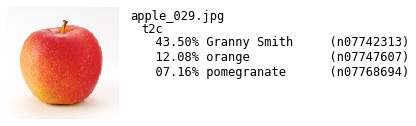

In [41]:
for img_path in validation_imgs:
    img = Image.open(img_path)
    pred = pred_for_o2c(t2c,img,labels=inet_labels)
    if show_pred(img_path,pred,model_id='t2c')is None : break

Well - it worked!  (credit goes to lucky instead of smart)... now save the corrected model

In [42]:
t2c.save(t2c_path.as_posix())

## Predictions - Compare Original and Converted Models

Specify the models to be included in the results and the parameters needed to run them.    
Create a [**Classifier**](https://mcsieber.github.io/pred_help.html#pred_help.Classifier) that uses the three models we've instantiated.  
Generate a prediction from each of the models for every image. Save the results and compare.  

In [47]:
params = { 
    'torch': PredParams( runtime=torchm, func=pred_for_torch, labels=inet_labels, imgsize=300 ),
    't2o'  : PredParams( runtime=t2o_rt, func=pred_for_onnx,  labels=inet_labels, imgsize=300 ),
    't2c'  : PredParams( runtime=t2c,    func=pred_for_o2c,   labels=inet_labels, imgsize=300 ),
    # additional models would go here
}

In [48]:
models = Classifier(params, top_count=3, resize_method=Image.NEAREST)

**Predictions** - Classify the images and capture the 'top_count' predictions made by each model for each image.

In [ ]:
models.classify(test_imgs);

### Agreement?
Some quick agreement checks. See notebook [40-compare-torch-onnx-coreml](40-compare-torch-onnx-coreml.ipynb) for more. 

How often do the original model and the converted model agree on the top prediction?  
Create boolen arrays to tabulate those images for which the top classes agree.  
(This sort of computation will be moved into the Results class next iteration)

In [57]:
tc = models.top_classes
tp = models.top_probs
#
TORCH = models.m2i('torch') # Model abbr to Model # (index)
T2O   = models.m2i('t2o')   
T2C   = models.m2i('t2c')

In [58]:
# T2O Agreement
t2o_agree = tc[TORCH,:,0] == tc[T2O,:,0]
toa = t2o_agree
f"TORCH and T2O agree on {toa.sum()} out of {toa.size} images, or {toa.sum()/toa.size:2.2%}"

'TORCH and T2O agree on 29 out of 29 images, or 100.00%'

In [59]:
# T2C Agreement
t2c_agree = tc[TORCH,:,0] == tc[T2C,:,0]
tca = t2c_agree
f"TORCH and T2C agree on {tca.sum()} out of {tca.size} images, or {tca.sum()/tca.size:2.2%}"

'TORCH and T2C agree on 29 out of 29 images, or 100.00%'

## Show Results 
Create a [**Results**](https://mcsieber.github.io/pred_help.html#pred_help) object to show results

In [60]:
results = Results(models)


Showing results [12, 17, 19, 25, 28] 
  and top 2 probabilities for each model


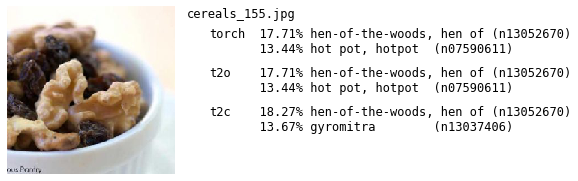

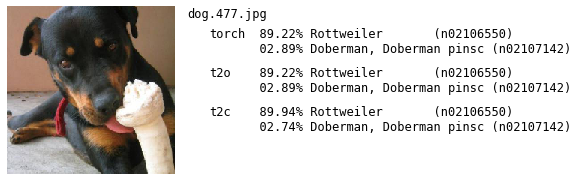

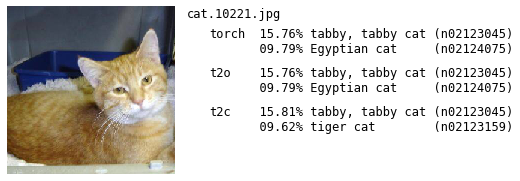

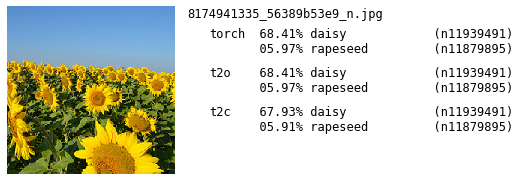

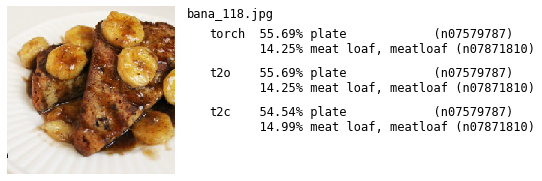

In [61]:
results.show_random()